# Almgren and Chriss Model For Optimal Execution of Portfolio Transactions

### Introduction

We consider the execution of portfolio transactions with the aim of minimizing a combination of risk and transaction costs arising from permanent and temporary market impact. As an example, assume that you have a certain number of stocks that you want to sell within a given time frame. If you place this sell order directly to the market as it is, transaction costs may rise due to temporary market impact. On the other hand, if you split up into pieces in time, cost may rise due to volatility in the stock price.

Almgren and Chriss (paper Robert Almgren - Neil Chriss) provided a solution to this problem by assuming the permanent and temporary market impact functions are linear functions of the rate of trading, and that stock prices follow a discrete arithmetic random walk.

In this notebook, we will take a look at the model used by Almgren and Chriss to solve the optimal liquidation problem. We will start by stating the formal definitions of *trading trajectory*, *trading list*, and *trading strategy* for liquidating a single stock.

### Trading Trajectory, Trading List, and Trading Strategy

We define trading trajectory, trading list, and trading strategy just as Almgren and Chriss did in their paper. Suppose we hold $X$ shares of a stock that we want to liquidate before time $T$. Divide $T$ into $N$ intervals of length $\tau=\frac{T}{N}$ and define:

- $t_k = k\tau$ to be discrete times, where $k = 0,..,N$.


- A **trading trajectory** to be the list $(x_0,..,x_N)$, where $x_k$ is the number of shares we plan to hold at time $t_k$. We require that our initial position $x_0 = X$, and that at liquidation time $T$, $x_N = 0$. 


- A **trading list** to be $(n_1,..,n_N)$, $n_k =  x_{k-1} - x_k$ as the number of shares that we will sell between times $t_{k-1}$ and $t_k$.


- A **trading strategy** as a rule for determining $n_k$ from the information available at time $t_{k-1}$.

Below, we can see a visual example of a trading trajectory, for $N = 12$.

<img src="./text_images/trajectory.png" width="600" height="600">

## Price Dynamics

We will assume that the stock price evolves according to a discrete arithmetic random walk:

\begin{equation}
S_k = S_{k-1} + \sigma \tau^{1/2} \xi_k
\end{equation}

for $k = 1,..,N$ and where: 

$$S_k = \text{ stock price at time $k$}\hspace{21.9cm}$$

$$\sigma = \text{ standard deviation of the fluctuations in stock price}\hspace{16.3cm}$$

$$\tau = \text{ length of discrete time interval}\hspace{20.2cm}$$

$$\xi_k = \text{ draws from independent random variables}\hspace{17.8cm}$$

We will denote the initial stock price as $S_0$. The role of $\xi_k$ is to simulate random price fluctuations using random numbers drawn from a Normal Gaussian distribution with zero mean and unit variance. The code below shows us what this price model looks like, for an initial stock price of $S_0 =50$ dollars, a standard deviation of price fluctuations of $\sigma = 0.379$, and a discrete time interval of $\tau = 1$. 

### You can see this price dynamics here:

Average Stock Price: $49.15
Standard Deviation in Stock Price: $26.96


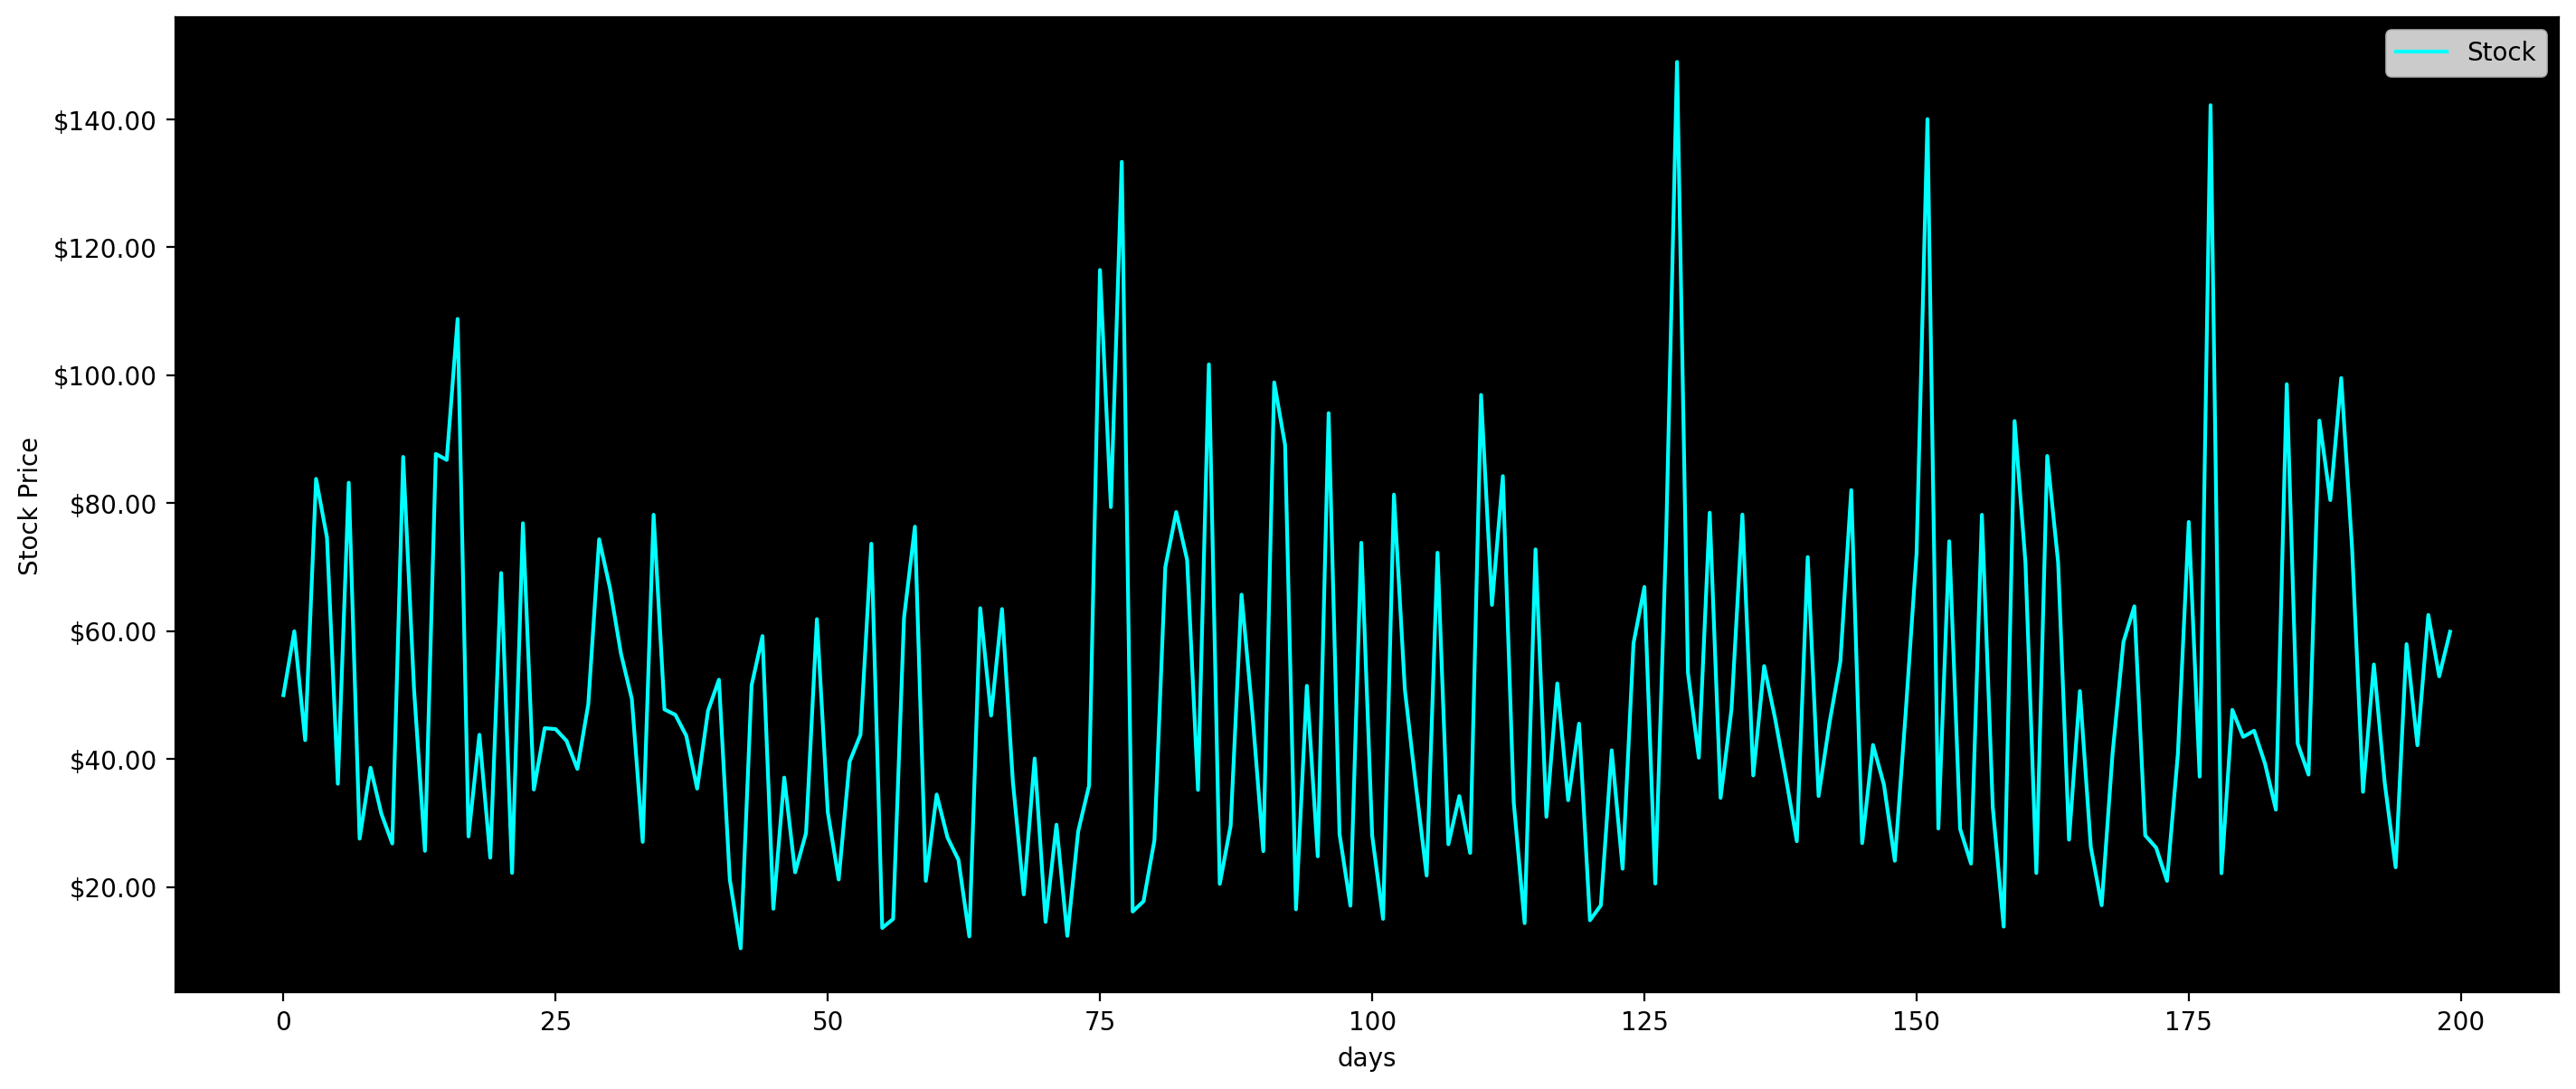

In [132]:
%matplotlib inline

import matplotlib.pyplot as plt
import syntheticChrissAlmgren as sca
# Add-on : Hide Matplotlib deprecate warnings
import warnings
warnings.filterwarnings("ignore")
# High resolution plot outputs for retina display
%config InlineBackend.figure_format = 'retina'

# utils file in the root
import utils
import importlib
importlib.reload(utils)
importlib.reload(sca)

# Set the default figure size
plt.rcParams['figure.figsize'] = [17.0, 7.0]

# Set the number of days to follow the stock price
n_days = 200

# Plot the stock price as a function of time
utils.plot_price_model(seed = 1, num_days = n_days)

## Market Impact

As we learned previously the price of a stock is affected by market impact that occurs every time we sell a stock. In their model, Almgren and Chriss distinguish between two types of market impact, permanent and temporary market impact. We will now add these two factors into our price model.

### Permanent Impact

Permanent market impact refers to changes in the equilibrium price of a stock as a direct function of our trading. Permanent market impact is called *permanent* because its effect persists for the entire liquidation period, $T$. We will denote the permanent price impact as $g(v)$, and will add it to our price model:

\begin{equation}
S_k = S_{k-1} + \sigma \tau^{1/2} \xi_k - \tau g\left(\frac{n_k}{\tau}\right)
\end{equation}

Here, we assumed the permanent impact function, $g(v)$, is a linear function of the trading rate, $v = n_k / \tau$. We will take $g(v)$ to have the form:

\begin{equation}
g(v) = \gamma \left(\frac{n_k}{\tau}\right)
\end{equation}

where $\gamma$ is a constant and has units of ($dollar/share^2$). Replacing this in the above equation we get:

\begin{equation}
S_k = S_{k-1} + \sigma \tau^{1/2} \xi_k - \gamma n_k
\end{equation}

With this form, we can see that for each $n$ shares that we sell, we will depress the stock price permanently by $n\gamma$, regardless of the time we take to sell the stocks.

### Temporary Impact

Temporary market impact refers to temporary imbalances in supply and demand caused by our trading. This leads to temporary price movements away from equilibrium. Temporary market impact is called *temporary* because its effect
dissipates by the next trading period. We will denote the temporary price impact as $h(v)$. Given this, the actual stock price at time $k$ is given by:

\begin{equation}
\tilde{S_k} = S_{k-1} - h\left(\frac{n_k}{\tau}\right)
\end{equation}

**$\tilde{S_k}$ is the price we see when we want to sell our shares at time $k$.**

Where, we have again assumed the temporary impact function, $h(v)$, is a linear function of the trading rate, $v = n_k / \tau$. We will take $h(v)$ to have the form:

\begin{equation}
h(v) = \epsilon \sin(n_k) + \eta \left(\frac{n_k}{\tau}\right)
\end{equation}

where $\epsilon$ and $\eta$ are constants with units $(dollar/share)$ and $(dollar \times time/share^2)$, respectively. It is important to note that $h(v)$ does not affect the price $S_k$.

## Capture

We define the **Capture** to be the total profits resulting from trading along a particular trading trajectory, upon completion of all trades. We can compute the capture via:

\begin{equation}
\sum\limits_{k=1}^{N} n_k \tilde{S_k} = X S_0 + \sum\limits_{k=1}^{N} \left(\sigma \tau^{1/2} \xi_k - \tau g\left(\frac{n_k}{\tau}\right)\right) x_k - \sum\limits_{k=1}^{N} n_k h\left(\frac{n_k}{\tau}\right)
\end{equation}

As we can see this is the sum of the product of the number of shares $n_k$ that we sell in each time interval, times the effective price per share $\tilde{S_k}$ received on that sale.

## Implementation Shortfall

We define the **Implementation Shortfall** as the total cost of trading and is given by:

\begin{equation}
I_s = X S_0 - \sum_{k = 1}^N n_k \tilde{S_k}
\end{equation}

This is what we seek to minimize when determining the best trading strategy!

Note that since $\xi_k$ is random, so is the implementation shortfall. Therefore, we have to frame the minimization problem in terms of the expectation value of the shortfall and its corresponding variance. We'll refer to $E(x)$ as the expected shortfall and $V(x)$ as the variance of the shortfall. Simplifying the above equation for $I_s$, is easy to see that:

\begin{equation}
E(x) = \sum\limits_{k=1}^{N} \tau x_k g\left(\frac{n_k}{\tau}\right) + \sum\limits_{k=1}^{N} n_k h\left(\frac{n_k}{\tau}\right)
\end{equation}

and

\begin{equation}
V(x) = \sigma^2 \sum\limits_{k=1}^{N} \tau {x_k}^2
\end{equation}

The units of $E(x)$ are dollars and the units of $V(x)$ are dollars squared. So now, we can reframe our minimization problem in terms of $E(x)$ and $V(x)$.
For a given level of variance of shortfall, $V(x)$, we seek to minimize the expectation of shortfall, $E(x)$. In the next section we will see how to solve this problem.

## Utility Function

Our goal now is to find the strategy that has the minimum expected shortfall $E(x)$ for a given maximum level of variance $V(x) \ge 0$. This constrained optimization problem can be solved by introducing a Lagrange multiplier $\lambda$. Therefore, our problem reduces to finding the trading strategy that minimizes the **Utility Function** $U(x)$:

\begin{equation}
U(x) = E(x) + \lambda V(x)
\end{equation}

The parameter $\lambda$ is referred to as **trader’s risk aversion** and controls how much we penalize the variance relative to the expected shortfall.  

The intuition of this utility function can be thought of as follows. Consider a stock which exhibits high price volatility and thus a high risk of price movement away from the equilibrium price. A risk averse trader would prefer to trade a large portion of the volume immediately, causing a known price impact, rather than risk trading in small increments at successively adverse prices. Alternatively, if the price is expected to be stable over the liquidation period, the trader would rather split the trade into smaller sizes to avoid price impact. This trade-off between speed of execution and risk of price movement is ultimately what governs the structure of the resulting trade list.


# Optimal Trading Strategy

Almgren and Chriss solved the above problem and showed that for each value
of risk aversion there is a uniquely determined optimal execution strategy. The details of their derivation is discussed in their paper. Here, we will just state the general solution. 

The optimal trajectory is given by:

\begin{equation}
x_j = \frac{\sinh \left( \kappa \left( T-t_j\right)\right)}{ \sinh (\kappa T)}X, \hspace{1cm}\text{ for } j=0,...,N
\end{equation}

and the associated trading list:

\begin{equation}
n_j = \frac{2 \sinh \left(\frac{1}{2} \kappa \tau \right)}{ \sinh \left(\kappa T\right) } \cosh \left(\kappa \left(T - t_{j-\frac{1}{2}}\right)\right) X, \hspace{1cm}\text{ for } j=1,...,N
\end{equation}

where $t_{j-1/2} = (j-\frac{1}{2}) \tau$. The expected shortfall and variance of the optimal trading strategy are given by:

<img src="./text_images/eq.png" width="600" height="600">

In the above equations $\kappa$ is given by:

\begin{align*}
&\kappa = \frac{1}{\tau}\cosh^{-1}\left(\frac{\tau^2}{2}\tilde{\kappa}^2 + 1\right)
\end{align*}

where:

\begin{align*}
&\tilde{\kappa}^2 = \frac{\lambda \sigma^2}{\tilde{\eta}} = \frac{\lambda \sigma^2}{\eta \left(1-\frac{\gamma \tau}{2 \eta}\right)}
\end{align*}

